In [1]:
import os, glob, math, random, json, time, re
import cv2
import numpy as np
from typing import List, Tuple, Dict
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, random_split
from sklearn.model_selection import train_test_split
import albumentations as A
from albumentations.pytorch import ToTensorV2
import segmentation_models_pytorch as smp
from collections import defaultdict
import matplotlib.pyplot as plt

/mhgp004-v1/Nuvo-Chennai/lk57288c/.local/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
train_image_dirs = [
    "/mhgp004-v1/Nuvo-Chennai/lk57288c/2 Stage_Model/DRIVE_AV/training/images", 
    "/mhgp004-v1/Nuvo-Chennai/lk57288c/2 Stage_Model/HRF_AV/training/images",
    "/mhgp004-v1/Nuvo-Chennai/lk57288c/RR_WNET/Fundus-AVSeg/images",
    "/mhgp004-v1/Nuvo-Chennai/lk57288c/RR_WNET/LES_AV/training/images"]

train_label_dirs = [
    "/mhgp004-v1/Nuvo-Chennai/lk57288c/2 Stage_Model/DRIVE_AV/training/label", 
    "/mhgp004-v1/Nuvo-Chennai/lk57288c/2 Stage_Model/HRF_AV/training/label",
    "/mhgp004-v1/Nuvo-Chennai/lk57288c/RR_WNET/Fundus-AVSeg/annotation",
    "/mhgp004-v1/Nuvo-Chennai/lk57288c/RR_WNET/LES_AV/training/label"]

test_image_dirs1 = [
    "/mhgp004-v1/Nuvo-Chennai/lk57288c/2 Stage_Model/DRIVE_AV/test/images"]

test_label_dirs1 = [
    "/mhgp004-v1/Nuvo-Chennai/lk57288c/2 Stage_Model/DRIVE_AV/test/label"]

test_image_dirs2 = [
    "/mhgp004-v1/Nuvo-Chennai/lk57288c/2 Stage_Model/HRF_AV/test/images"]

test_label_dirs2 = [
    "/mhgp004-v1/Nuvo-Chennai/lk57288c/2 Stage_Model/HRF_AV/test/label"]

test_image_dirs3 = [
    "/mhgp004-v1/Nuvo-Chennai/lk57288c/RR_WNET/LES_AV/test/images"]

test_label_dirs3 = [
    "/mhgp004-v1/Nuvo-Chennai/lk57288c/RR_WNET/LES_AV/test/label"]

def print_image_info(image_dirs, exts=(".png", ".jpg", ".jpeg", ".tif")):
    all_images = []
    
    for d in image_dirs:
        for p in glob.glob(os.path.join(d, "**", "*"), recursive=True):
            if p.lower().endswith(exts):
                all_images.append(p)
    
    print(f"Total number of images: {len(all_images)}")

    # print size of first few images for reference
    for p in all_images[:1]:  # just show first 5 to avoid long output
        img = cv2.imread(p)
        if img is not None:
            h, w, c = img.shape
            print(f"{os.path.basename(p)} -> Size: {w}x{h}, Channels: {c}")
        else:
            print(f"Could not read: {p}")

print_image_info(train_image_dirs)
print_image_info(train_label_dirs)
print_image_info(test_image_dirs1)
print_image_info(test_label_dirs1)
print_image_info(test_image_dirs2)
print_image_info(test_label_dirs2)
print_image_info(test_image_dirs3)
print_image_info(test_label_dirs3)

Total number of images: 146
drive_train_img7.png -> Size: 565x584, Channels: 3
Total number of images: 146
drive_train_label2.png -> Size: 565x584, Channels: 3
Total number of images: 20
drive_test_img11.png -> Size: 565x584, Channels: 3
Total number of images: 20
drive_test_label8.png -> Size: 565x584, Channels: 3
Total number of images: 30
HRF_test_img5.png -> Size: 3504x2336, Channels: 3
Total number of images: 30
HRF_test_label7.png -> Size: 3504x2336, Channels: 3
Total number of images: 11
6.png -> Size: 1620x1444, Channels: 3
Total number of images: 11
6.png -> Size: 1620x1444, Channels: 3


/tmp/ipykernel_1023377/2882704891.py:18: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array(X_data), np.array(y_data)


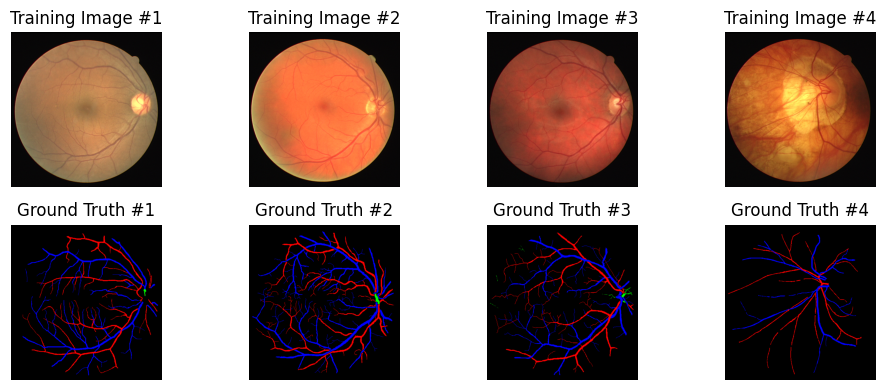

In [3]:

def load_images_from_dirs(image_dirs, label_dirs):
    X_data, y_data = [], []
    for img_dir, lbl_dir in zip(image_dirs, label_dirs):
        img_files = sorted(os.listdir(img_dir))
        lbl_files = sorted(os.listdir(lbl_dir))
        
        for img_file, lbl_file in zip(img_files, lbl_files):
            img_path = os.path.join(img_dir, img_file)
            lbl_path = os.path.join(lbl_dir, lbl_file)
            
            image = cv2.imread(img_path)
            image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
            label = cv2.imread(lbl_path)
            label = cv2.cvtColor(label, cv2.COLOR_BGR2RGB)
            
            X_data.append(image)
            y_data.append(label)
    return np.array(X_data), np.array(y_data)

def show_full_images(X_data, y_data, num_samples=3):
    plt.figure(figsize=(10, 4))
    for i in range(num_samples):
        plt.subplot(2, num_samples, i + 1)
        plt.title(f"Training Image #{i+1}")
        plt.imshow(X_data[i])
        plt.axis('off')

        plt.subplot(2, num_samples, i + 1 + num_samples)
        plt.title(f"Ground Truth #{i+1}")
        plt.imshow(y_data[i])
        plt.axis('off')

    plt.tight_layout()
    plt.show()

# Load data and visualize
X_data, y_data = load_images_from_dirs(train_image_dirs, train_label_dirs)
show_full_images(X_data, y_data, num_samples=4)


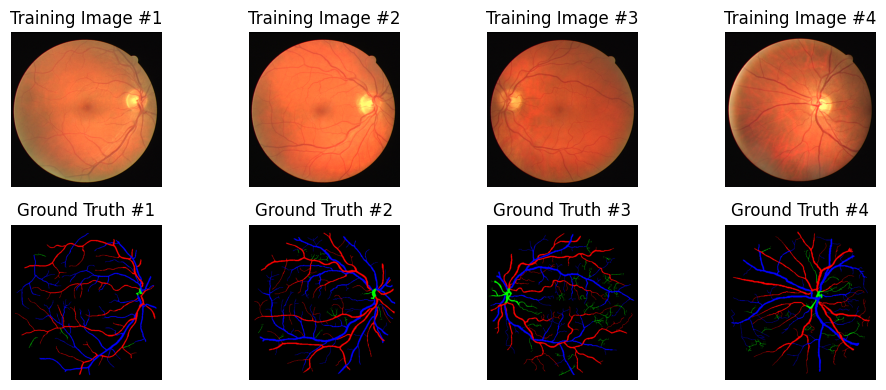

In [4]:
X_data, y_data = load_images_from_dirs(test_image_dirs1, test_label_dirs1)
show_full_images(X_data, y_data, num_samples=4)

In [5]:
# ----------------------------
# Robust triple builder (img <-> label/mask via token swap)
# ----------------------------

seed = 42
random.seed(seed); np.random.seed(seed); torch.manual_seed(seed); torch.cuda.manual_seed_all(seed)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

IMG_EXTS = (".png", ".jpg", ".jpeg", ".tif", ".tiff", ".bmp")

def glob_files(dirs, exts=IMG_EXTS):
    out = []
    for d in dirs:
        for p in glob.glob(os.path.join(d, "**", "*"), recursive=True):
            if p.lower().endswith(exts):
                out.append(p)
    return out

def stem(p):  # normalize to lowercase stem
    return os.path.splitext(os.path.basename(p))[0].lower()

def swap_token(s: str, old: str, new: str) -> str:
    cand = s.replace(old, new)
    if cand != s: 
        return cand
    # fallback: treat old as a token
    return re.sub(rf'(?i)(^|[_\-]){old}([_\-]|$)', rf'\1{new}\2', s)

def build_triples_by_filename(img_dirs, lbl_dirs):
    imgs = glob_files(img_dirs)
    lbls = glob_files(lbl_dirs)

    lbl_by = {stem(p): p for p in lbls}

    triples, missing_lbl = [], []

    for ip in imgs:
        s = stem(ip)
        lbl_s = swap_token(s, "img", "label")
        msk_s = swap_token(s, "img", "mask")

        lp = lbl_by.get(lbl_s) or lbl_by.get(s)

        if lp is None:
            missing_lbl.append(s); continue

        triples.append((ip, lp))

    # print(f"Found files: imgs={len(imgs)} lbls={len(lbls)} | paired={len(triples)}")
    if missing_lbl[:5]:
        print("Examples missing label:", missing_lbl[:5])
    return sorted(triples)

# ----------------------------
# Color → class (BGR-coded labels)
# ----------------------------
COLOR_TOL = 30
def bgr_to_class(mask_bgr: np.ndarray, tol=COLOR_TOL) -> np.ndarray:
    mb = mask_bgr[...,0].astype(np.int16)
    mg = mask_bgr[...,1].astype(np.int16)
    mr = mask_bgr[...,2].astype(np.int16)
    lab = np.zeros(mask_bgr.shape[:2], dtype=np.uint8)
    assigned = np.zeros(mask_bgr.shape[:2], dtype=bool)

    def assign(b,g,r, cls):
        cond = (np.abs(mb - b) <= tol) & (np.abs(mg - g) <= tol) & (np.abs(mr - r) <= tol) & (~assigned)
        lab[cond] = cls
        assigned[cond] = True

    for (b,g,r),cls in [((0,0,255),1), ((255,0,0),2), ((0,255,0),3)]:
        assign(b,g,r,cls)

    lab[~assigned] = 0
    return lab

def apply_green_CLAHE(img_bgr: np.ndarray, clip_limit=2.0, tile_grid_size=(8,8)) -> np.ndarray:
    b,g,r = cv2.split(img_bgr)
    clahe = cv2.createCLAHE(clipLimit=clip_limit, tileGridSize=tile_grid_size)
    g_enh = clahe.apply(g)
    return cv2.merge([b, g_enh, r])

# bgr_to_class(...) and apply_green_CLAHE(...) must be defined above.

class FundusAVDatasetV2(Dataset):
    def __init__(self, triples, img_size=512, encoder='resnet34', augment=True):
        self.triples  = triples
        self.img_size = img_size
        self.augment  = augment

        # encoder preprocessing (unused by default; see alt path below)
        self.preprocess_fn = smp.encoders.get_preprocessing_fn(encoder, 'imagenet')

        # Replace RRC with Resize + light geometric augs
        self.train_tf = A.Compose([
            A.Resize(height=img_size, width=img_size, interpolation=cv2.INTER_LINEAR),
            A.HorizontalFlip(p=0.5),
            A.VerticalFlip(p=0.5),
            A.RandomRotate90(p=0.5),
            A.ShiftScaleRotate(shift_limit=0.03, scale_limit=0.05, rotate_limit=20,
                               border_mode=cv2.BORDER_REFLECT_101, p=0.1),
            A.OneOf([
                A.GridDistortion(num_steps=5, distort_limit=0.2, border_mode=cv2.BORDER_REFLECT_101),
                A.ElasticTransform(alpha=50, sigma=7, border_mode=cv2.BORDER_REFLECT_101),
            ], p=0.25),
            A.OneOf([
                A.RandomBrightnessContrast(brightness_limit=0.2, contrast_limit=0.2),
                A.HueSaturationValue(hue_shift_limit=5, sat_shift_limit=15, val_shift_limit=15),
                A.CLAHE(clip_limit=(1.0, 4.0), tile_grid_size=(8,8)),
            ], p=0.3),
            A.GaussianBlur(blur_limit=(3,5), p=0.15),
            A.GaussNoise(var_limit=(5.0, 20.0), p=0.15),
        ])

        self.val_tf = A.Compose([
            A.Resize(height=img_size, width=img_size, interpolation=cv2.INTER_LINEAR),
        ])

        # Normalize with ImageNet RGB stats (we’ll convert BGR→RGB in __getitem__)
        self.to_tensor = A.Compose([
            A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
            ToTensorV2(),
        ])

    def __len__(self): 
        return len(self.triples)

    def __getitem__(self, idx):
        img_p, lbl_p = self.triples[idx]
        img_bgr = cv2.imread(img_p, cv2.IMREAD_COLOR)
        lbl_bgr = cv2.imread(lbl_p, cv2.IMREAD_COLOR)
        if img_bgr is None or lbl_bgr is None:
            raise RuntimeError(f"Could not read: {img_p}, {lbl_p}")

        img_bgr = apply_green_CLAHE(img_bgr, clip_limit=2.0, tile_grid_size=(8,8))
        lab     = bgr_to_class(lbl_bgr)
        img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)

        tf = self.train_tf if self.augment else self.val_tf
        data = tf(image=img_rgb, mask=lab)
        data = self.to_tensor(image=data["image"], mask=data["mask"])
        img_t  = data["image"]
        lab_t  = data["mask"].long()
        return img_t, lab_t, os.path.basename(img_p)

seed = 42
random.seed(seed); np.random.seed(seed); torch.manual_seed(seed); torch.cuda.manual_seed_all(seed)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

train_triples = build_triples_by_filename(train_image_dirs, train_label_dirs)
print("Total Train triples:", len(train_triples))
if len(train_triples) == 0:
    raise SystemExit("No paired triples found. Check naming/paths.")

test_triples1 = build_triples_by_filename(test_image_dirs1, test_label_dirs1)
test_triples2 = build_triples_by_filename(test_image_dirs2, test_label_dirs2)
test_triples3 = build_triples_by_filename(test_image_dirs3, test_label_dirs3)
print("Total Test1 triples:", len(test_triples1))
print("Total Test2 triples:", len(test_triples2))
print("Total Test3 triples:", len(test_triples3))
# if len(test_triples1) == 0:
#     raise SystemExit("No paired triples found. Check naming/paths.")

# ----------------------------
# Split + DataLoaders
# ----------------------------
# trainval_triples, test_triples = train_test_split(triples, test_size=0.10, shuffle=True, random_state=seed)
train_triples,  val_triples   = train_test_split(train_triples, test_size=0.15, shuffle=True, random_state=seed)
# print(f"Split -> train={len(train_triples)}  val={len(val_triples)}  test={len(test_triples)}")
print(f"Split -> Final train set length ={len(train_triples)}  Final val set length={len(val_triples)}")


IMG_SIZE   = 512
BATCH_SIZE = 4
NUM_WORKERS= 4

train_ds = FundusAVDatasetV2(train_triples, img_size=IMG_SIZE, encoder='resnet34', augment=True)
val_ds   = FundusAVDatasetV2(val_triples,   img_size=IMG_SIZE, encoder='resnet34', augment=False)
test_ds1  = FundusAVDatasetV2(test_triples1,  img_size=IMG_SIZE, encoder='resnet34', augment=False)
test_ds2  = FundusAVDatasetV2(test_triples2,  img_size=IMG_SIZE, encoder='resnet34', augment=False)
test_ds3  = FundusAVDatasetV2(test_triples3,  img_size=IMG_SIZE, encoder='resnet34', augment=False)

train_loader = DataLoader(train_ds, batch_size=2, shuffle=True, num_workers=0, pin_memory=False)
val_loader   = DataLoader(val_ds, batch_size=2, shuffle=True, num_workers=0, pin_memory=False)
test_loader1  = DataLoader(test_ds1, batch_size=2, shuffle=True, num_workers=0, pin_memory=False)
test_loader2  = DataLoader(test_ds2, batch_size=2, shuffle=True, num_workers=0, pin_memory=False)
test_loader3  = DataLoader(test_ds3, batch_size=2, shuffle=True, num_workers=0, pin_memory=False)

xb, yb, names = next(iter(train_loader))
print("Batch shapes:", xb.shape, yb.shape)

Total Train triples: 146
Total Test1 triples: 20
Total Test2 triples: 30
Total Test3 triples: 11
Split -> Final train set length =124  Final val set length=22
Batch shapes: torch.Size([2, 3, 512, 512]) torch.Size([2, 512, 512])


/mhgp004-v1/Nuvo-Chennai/lk57288c/.local/lib/python3.10/site-packages/albumentations/core/validation.py:114: UserWarning: ShiftScaleRotate is a special case of Affine transform. Please use Affine transform instead.
  original_init(self, **validated_kwargs)
/tmp/ipykernel_1023377/3425080612.py:112: UserWarning: Argument(s) 'var_limit' are not valid for transform GaussNoise
  A.GaussNoise(var_limit=(5.0, 20.0), p=0.15),


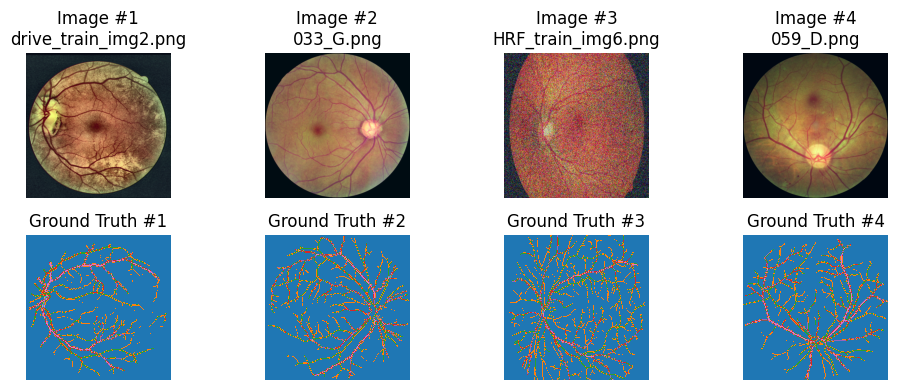

In [6]:
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader

def visualize_training_samples(train_ds, num_samples=3, batch_size=1):
    # Create a non-shuffled DataLoader
    train_iter = iter(DataLoader(train_ds, batch_size=batch_size, shuffle=False))
    
    X_data, y_data, names = [], [], []
    for _ in range(num_samples):
        img_t, lab_t, name = next(train_iter)
        
        # Convert to numpy and normalize image to [0,1]
        img = img_t[0].permute(1, 2, 0).cpu().numpy()
        img = (img - img.min()) / (img.max() - img.min() + 1e-8)
        lab = lab_t[0].cpu().numpy()
        
        X_data.append(img)
        y_data.append(lab)
        names.append(name[0])

    # Plot images and labels
    plt.figure(figsize=(10, 4))
    for i in range(num_samples):
        # Row 1: Training images
        plt.subplot(2, num_samples, i + 1)
        plt.title(f"Image #{i+1}\n{names[i]}")
        plt.imshow(X_data[i])
        plt.axis('off')

        # Row 2: Ground truth label maps
        plt.subplot(2, num_samples, i + 1 + num_samples)
        plt.title(f"Ground Truth #{i+1}")
        plt.imshow(y_data[i], cmap='tab10')
        plt.axis('off')

    plt.tight_layout()
    plt.show()

visualize_training_samples(train_ds, num_samples=4)

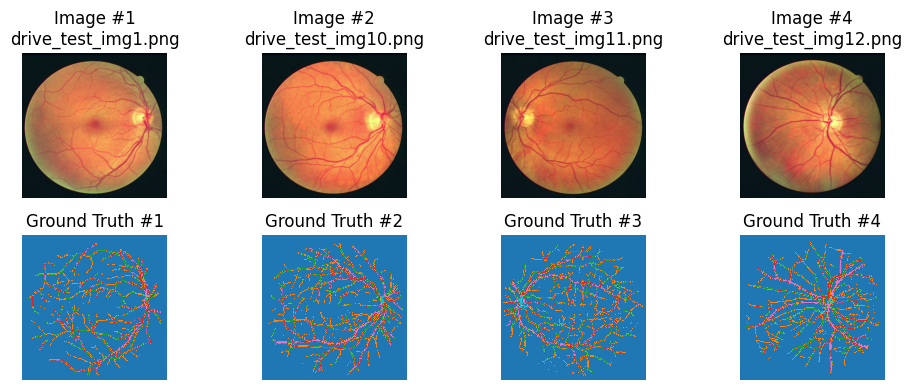

In [7]:
visualize_training_samples(test_ds1, num_samples=4)

In [8]:
# ----------------------------
# Losses and metrics
# ----------------------------
class DiceLoss(nn.Module):
    def __init__(self, num_classes=4, eps=1e-6):
        super().__init__()
        self.num_classes = num_classes
        self.eps = eps

    def forward(self, logits, targets):
        # logits: (B,C,H,W); targets: (B,H,W); fov: (B,1,H,W) or (B,H,W)

        probs = F.softmax(logits, dim=1)                         # (B,C,H,W)
        targets_oh = F.one_hot(targets, num_classes=self.num_classes)\
                       .permute(0,3,1,2).float()                 # (B,C,H,W)

        probs = probs 
        targets_oh = targets_oh

        dims = (0,2,3)
        intersect = torch.sum(probs * targets_oh, dims)          # (C,)
        denom = torch.sum(probs + targets_oh, dims).clamp_min(self.eps)
        dice = (2.0 * intersect + self.eps) / (denom + self.eps) # (C,)
        dice_fg = dice[1:].mean()                                 # exclude background
        return 1.0 - dice_fg

class MaskedCrossEntropy(nn.Module):
    def __init__(self, weight=None):
        super().__init__()
        self.weight = weight

    def forward(self, logits, targets,):
        # per-pixel CE
        ce = F.cross_entropy(logits, targets, weight=self.weight, reduction='none')  # (B,H,W)
        return ce.sum() / targets.numel()

class ComboLoss(nn.Module):
    def __init__(self, num_classes=4, ce_weight=None, alpha=0.5):
        super().__init__()
        self.ce = MaskedCrossEntropy(weight=ce_weight)
        self.dice = DiceLoss(num_classes=num_classes)
        self.alpha = alpha  # total = alpha * CE + (1-alpha) * Dice

    def forward(self, logits, targets):
        return self.alpha * self.ce(logits, targets) + (1.0 - self.alpha) * self.dice(logits, targets)

@torch.no_grad()
def per_class_dice(logits, targets, num_classes=4, eps=1e-6):
    probs = F.softmax(logits, dim=1)
    targets_oh = F.one_hot(targets, num_classes=num_classes).permute(0,3,1,2).float()
    probs, targets_oh = probs , targets_oh
    dims = (0,2,3)
    intersect = torch.sum(probs * targets_oh, dims)
    denom = torch.sum(probs + targets_oh, dims).clamp_min(eps)
    dice = (2.0 * intersect + eps) / (denom + eps)  # (C,)
    return dice.detach().cpu().numpy()
    # return dice.detach().cpu().numpy().astype(np.float64)

In [9]:
def build_model(
    arch="unet", 
    encoder="efficientnet-b4", 
    classes=4, 
    pretrained=True,
    vessel_ckpt_path="/mhgp004-v1/Nuvo-Chennai/lk57288c/unetpp_drive_best.pth",
    # vessel_ckpt_path="/mhgp004-v1/Nuvo-Chennai/lk57288c/2 Stage_Model/D2_UnetPlusPlus_0.833.pth",
    device=torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
):
    """
    Build U-Net or U-Net++ model with optional initialization:
      - pretrained=True  : ImageNet encoder initialization
      - pretrained="vessel" : Load weights from vessel segmentation checkpoint
      - pretrained=False : random initialization
    """
    encoder_weights = "imagenet" if pretrained is True else None

    # ---- Create model architecture ----
    if arch.lower() == "unet":
        model = smp.Unet(
            encoder_name=encoder,
            encoder_weights=encoder_weights,
            in_channels=3,
            classes=classes,
        )
    elif arch.lower() in ["unet++", "unetplusplus", "unet_plus_plus"]:
        model = smp.UnetPlusPlus(
            encoder_name=encoder,
            encoder_weights=encoder_weights,
            in_channels=3,
            classes=classes,
            decoder_attention_type=None,
        )
    else:
        raise ValueError("arch must be 'unet' or 'unet++'")

    # ---- Optionally load vessel segmentation checkpoint ----
    if pretrained == "vessel":
        if not os.path.exists(vessel_ckpt_path):
            raise FileNotFoundError(f"Checkpoint not found: {vessel_ckpt_path}")

        ckpt = torch.load(vessel_ckpt_path, map_location=device)

        # Handle different checkpoint structures (dict or wrapped in {'model': ...})
        state_dict = ckpt.get("model", ckpt)

        # Load only matching keys to avoid shape mismatch if classes differ
        model_dict = model.state_dict()
        compatible_dict = {k: v for k, v in state_dict.items() if k in model_dict and v.shape == model_dict[k].shape}
        model_dict.update(compatible_dict)
        model.load_state_dict(model_dict)

        print(f"Loaded {len(compatible_dict)} layers from vessel checkpoint for fine-tuning.")

    return model.to(device)


In [10]:
# ----------------------------
# Training loop (uses your existing loaders)
# ----------------------------
def fit(
    model,
    train_loader,
    val_loader,
    epochs=25,
    lr=3e-4,
    ce_class_weights=(0.2, 1.0, 1.0, 1.0),
    out_dir="./av_runs",
    num_classes=4,
    device=torch.device("cuda:0" if torch.cuda.is_available() else "cpu"),
    history_path = "2stg_history.json"
):
    os.makedirs(out_dir, exist_ok=True)
    model = model.to(device)

    ce_w = torch.tensor(ce_class_weights, dtype=torch.float32, device=device)
    criterion = ComboLoss(num_classes=num_classes, ce_weight=ce_w, alpha=0.6)
    optimizer = torch.optim.AdamW(model.parameters(), lr=lr, weight_decay=1e-4)
    scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=epochs)

    best_val = -1.0
    history = []

    for epoch in range(1, epochs + 1):
        # ---- train ----
        model.train()
        tr_loss = 0.0
        # running per-class dice (sum, then average by #batches at the end)
        tr_dice_sum = np.zeros(num_classes, dtype=np.float64)
        tr_batches = 0

        for imgs, labs, _ in train_loader:
            imgs, labs = imgs.to(device), labs.to(device)

            optimizer.zero_grad(set_to_none=True)
            logits = model(imgs)
            loss = criterion(logits, labs)
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
            optimizer.step()

            tr_loss += loss.item() * imgs.size(0)
            tr_dice_sum += per_class_dice(logits, labs, num_classes=num_classes)
            tr_batches += 1

        tr_loss /= max(1, len(train_loader.dataset))
        tr_dice = tr_dice_sum / max(1, tr_batches)

        # ---- validate ----
        model.eval()
        va_loss = 0.0
        va_dice_sum = np.zeros(num_classes, dtype=np.float64)
        va_batches = 0

        with torch.no_grad():
            for imgs, labs, _ in val_loader:
                
                imgs, labs = imgs.to(device), labs.to(device)
                logits = model(imgs)
                loss = criterion(logits, labs)
                va_loss += loss.item() * imgs.size(0)
                va_dice_sum += per_class_dice(logits, labs, num_classes=num_classes)
                va_batches += 1

        va_loss /= max(1, len(val_loader.dataset))
        va_dice = va_dice_sum / max(1, va_batches)
        scheduler.step()

        log = {
            "epoch": epoch,
            "train_loss": round(tr_loss, 6),
            "val_loss": round(va_loss, 6),
            "dice_bg": round(float(va_dice[0]), 4),
            "dice_artery": round(float(va_dice[1]), 4),
            "dice_vein": round(float(va_dice[2]), 4),
            "dice_cross": round(float(va_dice[3]), 4),
            "lr": scheduler.get_last_lr()[0],
        }
        history.append(log)
        print(log)

        # mean_fg = float(va_dice[1:].mean())
        # if mean_fg > best_val:
        #     best_val = mean_fg
        #     torch.save(
        #         {"model": model.state_dict(), "arch": type(model).__name__, "num_classes": num_classes},
        #         os.path.join(out_dir, "2stg_best.pt"),
        #     )

    with open(os.path.join(out_dir, history_path), "w") as f:
        json.dump(history, f, indent=2)

    return model


In [11]:
# NUM_CLASSES = 4
# device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

# # Case 1 – Efficientnet encoder (default)
# model = build_model(arch="unet++", encoder="efficientnet-b4", classes=NUM_CLASSES, pretrained=True)

# model = fit(model, train_loader, val_loader, epochs=20, lr=3e-4, out_dir="./av_runs", num_classes=NUM_CLASSES, device=device, history_path = "M1_history.json")

In [12]:
def colorize_mask(mask):
    COLOR_PALETTE = {
        0: (0, 0, 0),      # background
        1: (255, 0, 0),    # artery (red)
        2: (0, 0, 255),    # vein (blue)
        3: (0, 255, 0),    # crossing (green)
    }
    h, w = mask.shape
    color = np.zeros((h, w, 3), dtype=np.uint8)
    for cls, rgb in COLOR_PALETTE.items():
        color[mask == cls] = rgb
    return color

def visualize_validation_samples(model, val_loader, device, colorize_mask, num_samples=3, save_dir="./av_runs/val_viz"):

    # Ensure output directory exists
    os.makedirs(save_dir, exist_ok=True)
    
    model.eval()
    samples = []

    # ----------------------------
    # Collect validation samples
    # ----------------------------
    with torch.no_grad():
        for imgs, labs, names in val_loader:
            imgs = imgs.to(device)
            logits = model(imgs)
            preds = torch.argmax(torch.softmax(logits, dim=1), dim=1).cpu().numpy()
            labs = labs.cpu().numpy()
            imgs = imgs.cpu().numpy()
            for i in range(imgs.shape[0]):
                samples.append((imgs[i], labs[i], preds[i], names[i]))
                if len(samples) >= num_samples:
                    break
            if len(samples) >= num_samples:
                break

    # ----------------------------
    # Plot & Save results
    # ----------------------------
    for idx, (img, gt, pred, name) in enumerate(samples):
        # Denormalize image for display
        img_disp = np.transpose(img, (1, 2, 0))
        img_disp = (img_disp * np.array([0.229, 0.224, 0.225]) + np.array([0.485, 0.456, 0.406]))
        img_disp = np.clip(img_disp, 0, 1)

        # Mask outside FOV
        pred_masked = pred.copy()
        gt_masked = gt.copy()

        # Plot
        plt.figure(figsize=(10, 4))
        plt.subplot(1, 3, 1)
        plt.imshow(img_disp)
        plt.title("Image")
        plt.axis("off")

        plt.subplot(1, 3, 2)
        plt.imshow(colorize_mask(gt_masked))
        plt.title("Ground Truth")
        plt.axis("off")

        plt.subplot(1, 3, 3)
        plt.imshow(colorize_mask(pred_masked))
        plt.title("Prediction")
        plt.axis("off")

        plt.suptitle(name)
        plt.tight_layout()

        # Save the figure
        filename = os.path.join(save_dir, f"{idx+1:02d}_{name}.png")
        plt.savefig(filename, bbox_inches="tight")
        print(f"Saved visualization: {filename}")

        plt.show()

# visualize_validation_samples(model, val_loader, device, colorize_mask, num_samples=3, save_dir="./av_runs/val_viz")

In [13]:
import numpy as np
import torch

def compute_iou_per_class(pred, target, num_classes):
    """
    Compute IoU for each class in a single (H, W) prediction/target pair.
    Ignores classes with zero union (no pixels of that class).
    """
    ious = []
    for cls in range(num_classes):
        pred_inds = (pred == cls)
        target_inds = (target == cls)
        intersection = np.logical_and(pred_inds, target_inds).sum()
        union = np.logical_or(pred_inds, target_inds).sum()
        if union == 0:
            ious.append(np.nan)  # ignore this class (absent)
        else:
            ious.append(intersection / union)
    return ious

def evaluate_iou(model, val_loader, device, compute_iou_per_class, num_classes=4, verbose=True):

    model.eval()
    ious_all = []

    with torch.no_grad():
        for imgs, labs, _ in val_loader:
            imgs = imgs.to(device)
            logits = model(imgs)
            preds = torch.argmax(torch.softmax(logits, dim=1), dim=1).cpu().numpy()
            labs = labs.cpu().numpy()

            for i in range(preds.shape[0]):
                ious = compute_iou_per_class(preds[i], labs[i], num_classes=num_classes)
                ious_all.append(ious)

    # Convert list → array: shape (N, num_classes)
    ious_all = np.array(ious_all)

    # Per-class mean IoU (ignore NaNs)
    mean_ious = np.nanmean(ious_all, axis=0)

    # Exclude background (class 0) for final mIoU
    mean_miou = np.nanmean(mean_ious[1:])

    if verbose:
        print("Per-class Validation IoU:")
        print(f"  Background : {mean_ious[0]:.4f}")
        print(f"  Artery     : {mean_ious[1]:.4f}")
        print(f"  Vein       : {mean_ious[2]:.4f}")
        print(f"  Crossing   : {mean_ious[3]:.4f}")
        print(f"\nMean IoU (artery/vein/cross): {mean_miou:.4f}")

    return mean_ious, mean_miou

# mean_ious, mean_miou = evaluate_iou(model, val_loader, device, compute_iou_per_class)

In [14]:
# If not already defined
def colorize_mask(mask):
    COLOR_PALETTE = {
        0: (0, 0, 0),      # background
        1: (255, 0, 0),    # artery (red)
        2: (0, 0, 255),    # vein (blue)
        3: (0, 255, 0),    # crossing/uncertain (green)
    }
    h, w = mask.shape
    color = np.zeros((h, w, 3), dtype=np.uint8)
    for cls, rgb in COLOR_PALETTE.items():
        color[mask == cls] = rgb
    return color

def denormalize_imagenet(img_chw: np.ndarray):
    """img_chw: CxHxW in normalized ImageNet space -> HxWxC in [0,1]"""
    mean = np.array([0.485, 0.456, 0.406])
    std  = np.array([0.229, 0.224, 0.225])
    img = np.transpose(img_chw, (1, 2, 0))
    img = img * std + mean
    return np.clip(img, 0, 1)

def plot_test_predictions(model, test_loader, device, num_samples=6, save_dir=None):
    model.eval()
    samples = []

    with torch.no_grad():
        for imgs, labs, names in test_loader:
            imgs = imgs.to(device)
            logits = model(imgs)
            preds = torch.argmax(torch.softmax(logits, dim=1), dim=1).cpu().numpy()
            labs  = labs.cpu().numpy()
            imgs  = imgs.cpu().numpy()

            for i in range(imgs.shape[0]):
                samples.append((imgs[i], labs[i], preds[i], names[i]))
                if len(samples) >= num_samples:
                    break
            if len(samples) >= num_samples:
                break

    # Plot
    rows = len(samples)
    fig, axes = plt.subplots(rows, 3, figsize=(10, 4 * rows))
    if rows == 1:
        axes = np.expand_dims(axes, axis=0)

    for r, (img, gt, pred, name) in enumerate(samples):
        img_disp = denormalize_imagenet(img)
        pred_masked = pred
        gt_masked = gt

        axes[r, 0].imshow(img_disp)
        axes[r, 0].set_title(f"Image\n{name}")
        axes[r, 0].axis("off")

        axes[r, 1].imshow(colorize_mask(gt_masked))
        axes[r, 1].set_title("Ground Truth")
        axes[r, 1].axis("off")

        axes[r, 2].imshow(colorize_mask(pred_masked))
        axes[r, 2].set_title("Prediction")
        axes[r, 2].axis("off")

    plt.tight_layout()
    plt.show()

    # Save panels if requested
    if save_dir is not None:
        os.makedirs(save_dir, exist_ok=True)
        for (img, gt, pred, name) in samples:
            img_disp = denormalize_imagenet(img)
            pred_masked = pred
            gt_masked = gt

            plt.figure(figsize=(12, 4))
            plt.subplot(1, 3, 1); plt.imshow(img_disp); plt.title("Image"); plt.axis("off")
            plt.subplot(1, 3, 2); plt.imshow(colorize_mask(gt_masked)); plt.title("Ground Truth"); plt.axis("off")
            plt.subplot(1, 3, 3); plt.imshow(colorize_mask(pred_masked)); plt.title("Prediction"); plt.axis("off")
            plt.suptitle(name); plt.tight_layout()
            out_path = os.path.join(save_dir, f"{os.path.splitext(name)[0]}_viz.png")
            plt.savefig(out_path, dpi=150)
            plt.close()

# show 6 test predictions on screen, and also save PNGs
# plot_test_predictions(model, test_loader, device, num_samples=3, save_dir="./av_runs/test_viz")


In [15]:
def compute_iou_per_class(pred, target, num_classes):
    """
    Compute IoU for each class in a single (H, W) prediction/target pair.
    Ignores classes with zero union (no pixels of that class).
    """
    ious = []
    for cls in range(num_classes):
        pred_inds = (pred == cls)
        target_inds = (target == cls)
        intersection = np.logical_and(pred_inds, target_inds).sum()
        union = np.logical_or(pred_inds, target_inds).sum()
        if union == 0:
            ious.append(np.nan)  # ignore this class
        else:
            ious.append(intersection / union)
    return ious

def evaluate_dataset_iou(model, data_loader, device, compute_iou_per_class, num_classes=4, split_name="Test"):
    """
    Returns:
        mean_ious (np.ndarray): Per-class mean IoUs.
        mean_miou (float): Mean IoU excluding background (class 0).
    """
    model.eval()
    ious_all = []

    with torch.no_grad():
        for imgs, labs, _ in data_loader:
            imgs = imgs.to(device)
            logits = model(imgs)
            preds = torch.argmax(torch.softmax(logits, dim=1), dim=1).cpu().numpy()
            labs = labs.cpu().numpy()

            for i in range(preds.shape[0]):
                ious = compute_iou_per_class(preds[i], labs[i], num_classes=num_classes)
                ious_all.append(ious)

    # Convert to numpy array (N, num_classes)
    ious_all = np.array(ious_all)

    # Per-class mean IoU (ignore NaNs)
    mean_ious = np.nanmean(ious_all, axis=0)

    # Exclude background (class 0) for final mIoU
    mean_miou = np.nanmean(mean_ious[1:])

    # Print formatted results
    print(f"{split_name} Set IoU Results")
    print("-" * 26)
    print(f"  Background : {mean_ious[0]:.4f}")
    print(f"  Artery     : {mean_ious[1]:.4f}")
    print(f"  Vein       : {mean_ious[2]:.4f}")
    print(f"  Crossing   : {mean_ious[3]:.4f}")
    print(f"\nMean IoU (artery/vein/cross): {mean_miou:.4f}")

    return mean_ious, mean_miou

# mean_ious, mean_miou = evaluate_dataset_iou(model, test_loader, device, compute_iou_per_class, num_classes=4, split_name="Test")


In [ ]:
# UNet

NUM_CLASSES = 4
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

model3 = build_model(arch="unet++", encoder="efficientnet-b4", classes=NUM_CLASSES, pretrained=True)

model = fit(model3, train_loader, val_loader, epochs=50, lr=3e-4, out_dir="./av_runs", num_classes=NUM_CLASSES, device=device, history_path = "M3_history.json")

visualize_validation_samples(model, val_loader, device, colorize_mask, num_samples=10, save_dir="./M3_av_runs/val_viz")
mean_ious, mean_miou = evaluate_iou(model, val_loader, device, compute_iou_per_class)

plot_test_predictions(model, test_loader1, device, num_samples=20, save_dir="./M3_av_runs/drive_test")
mean_ious, mean_miou = evaluate_dataset_iou(model, test_loader1, device, compute_iou_per_class, num_classes=4, split_name="Test1")

plot_test_predictions(model, test_loader2, device, num_samples=30, save_dir="./M3_av_runs/hrf_test")
mean_ious, mean_miou = evaluate_dataset_iou(model, test_loader2, device, compute_iou_per_class, num_classes=4, split_name="Test2")

plot_test_predictions(model, test_loader3, device, num_samples=11, save_dir="./M3_av_runs/les_test")
mean_ious, mean_miou = evaluate_dataset_iou(model, test_loader3, device, compute_iou_per_class, num_classes=4, split_name="Test3")

{'epoch': 1, 'train_loss': 0.486003, 'val_loss': 0.402358, 'dice_bg': 0.8741, 'dice_artery': 0.2625, 'dice_vein': 0.3558, 'dice_cross': 0.0027, 'lr': 0.0002997040092642407}
{'epoch': 2, 'train_loss': 0.378353, 'val_loss': 0.340121, 'dice_bg': 0.9401, 'dice_artery': 0.4592, 'dice_vein': 0.4934, 'dice_cross': 0.0034, 'lr': 0.0002988172051971717}
{'epoch': 3, 'train_loss': 0.339374, 'val_loss': 0.303701, 'dice_bg': 0.9549, 'dice_artery': 0.5464, 'dice_vein': 0.5944, 'dice_cross': 0.0049, 'lr': 0.0002973430876093033}
{'epoch': 4, 'train_loss': 0.31845, 'val_loss': 0.288363, 'dice_bg': 0.964, 'dice_artery': 0.5969, 'dice_vein': 0.635, 'dice_cross': 0.0103, 'lr': 0.00029528747416929463}
{'epoch': 5, 'train_loss': 0.313569, 'val_loss': 0.278731, 'dice_bg': 0.9661, 'dice_artery': 0.6161, 'dice_vein': 0.6514, 'dice_cross': 0.0287, 'lr': 0.00029265847744427303}
{'epoch': 6, 'train_loss': 0.309428, 'val_loss': 0.263253, 'dice_bg': 0.9694, 'dice_artery': 0.6263, 'dice_vein': 0.663, 'dice_cross': 0

In [ ]:
# unetpp_drive_best

model1 = build_model(arch="unet++", encoder="efficientnet-b4", classes=NUM_CLASSES, pretrained="vessel", vessel_ckpt_path="/mhgp004-v1/Nuvo-Chennai/lk57288c/unetpp_drive_best.pth")

model = fit(model1, train_loader, val_loader, epochs=50, lr=3e-4, out_dir="./av_runs", num_classes=NUM_CLASSES, device=device, history_path = "M1_history.json")

visualize_validation_samples(model, val_loader, device, colorize_mask, num_samples=10, save_dir="./M1_av_runs/val_viz")
mean_ious, mean_miou = evaluate_iou(model, val_loader, device, compute_iou_per_class)

plot_test_predictions(model, test_loader1, device, num_samples=20, save_dir="./M1_av_runs/drive_test")
mean_ious, mean_miou = evaluate_dataset_iou(model, test_loader1, device, compute_iou_per_class, num_classes=4, split_name="Test1")

plot_test_predictions(model, test_loader2, device, num_samples=30, save_dir="./M1_av_runs/hrf_test")
mean_ious, mean_miou = evaluate_dataset_iou(model, test_loader2, device, compute_iou_per_class, num_classes=4, split_name="Test2")

plot_test_predictions(model, test_loader3, device, num_samples=11, save_dir="./M1_av_runs/les_test")
mean_ious, mean_miou = evaluate_dataset_iou(model, test_loader3, device, compute_iou_per_class, num_classes=4, split_name="Test3")

In [ ]:
# D2_UnetPlusPlus_0

model2 = build_model(arch="unet++", encoder="efficientnet-b4", classes=NUM_CLASSES, pretrained="vessel", vessel_ckpt_path="/mhgp004-v1/Nuvo-Chennai/lk57288c/2 Stage_Model/D2_UnetPlusPlus_0.833.pth")

model = fit(model2, train_loader, val_loader, epochs=50, lr=3e-4, out_dir="./av_runs", num_classes=NUM_CLASSES, device=device, history_path = "M2_history.json")

visualize_validation_samples(model, val_loader, device, colorize_mask, num_samples=10, save_dir="./M2_av_runs/val_viz")
mean_ious, mean_miou = evaluate_iou(model, val_loader, device, compute_iou_per_class)

plot_test_predictions(model, test_loader1, device, num_samples=20, save_dir="./M2_av_runs/drive_test")
mean_ious, mean_miou = evaluate_dataset_iou(model, test_loader1, device, compute_iou_per_class, num_classes=4, split_name="Test1")

plot_test_predictions(model, test_loader2, device, num_samples=30, save_dir="./M2_av_runs/hrf_test")
mean_ious, mean_miou = evaluate_dataset_iou(model, test_loader2, device, compute_iou_per_class, num_classes=4, split_name="Test2")

plot_test_predictions(model, test_loader3, device, num_samples=11, save_dir="./M2_av_runs/les_test")
mean_ious, mean_miou = evaluate_dataset_iou(model, test_loader3, device, compute_iou_per_class, num_classes=4, split_name="Test3")

In [6]:
# import os
# import cv2
# import numpy as np
# from glob import glob

# # --------------------------------------------------
# # BGR → class index mapping
# # --------------------------------------------------
# COLOR_TOL = 30

# def bgr_to_class(mask_bgr, tol=COLOR_TOL):
#     mb = mask_bgr[..., 0].astype(np.int16)
#     mg = mask_bgr[..., 1].astype(np.int16)
#     mr = mask_bgr[..., 2].astype(np.int16)

#     lab = np.zeros(mask_bgr.shape[:2], dtype=np.uint8)
#     assigned = np.zeros(mask_bgr.shape[:2], dtype=bool)

#     def assign(b, g, r, cls):
#         cond = (np.abs(mb - b) <= tol) & (np.abs(mg - g) <= tol) & (np.abs(mr - r) <= tol) & (~assigned)
#         lab[cond] = cls
#         assigned[cond] = True

#     # mapping
#     for (b, g, r), cls in [((0,0,255),1), ((255,0,0),2), ((0,255,0),3)]:
#         assign(b,g,r,cls)

#     lab[~assigned] = 0
#     return lab

# # --------------------------------------------------
# # Metrics
# # --------------------------------------------------
# def dice_score(gt, pred, cls):
#     gt_c = (gt == cls)
#     pred_c = (pred == cls)

#     inter = np.logical_and(gt_c, pred_c).sum()
#     denom = gt_c.sum() + pred_c.sum()

#     if denom == 0:
#         return 1.0
#     return 2 * inter / denom

# def iou_score(gt, pred, cls):
#     gt_c = (gt == cls)
#     pred_c = (pred == cls)

#     inter = np.logical_and(gt_c, pred_c).sum()
#     union = np.logical_or(gt_c, pred_c).sum()

#     if union == 0:
#         return 1.0
#     return inter / union

# # --------------------------------------------------
# # Paths
# # --------------------------------------------------

# # label_dir = "/mhgp004-v1/Nuvo-Chennai/lk57288c/Automorph outputs/Drive lable"
# # pred_dir  = "/mhgp004-v1/Nuvo-Chennai/lk57288c/Automorph outputs/Drive_automorph"

# label_dir = "/mhgp004-v1/Nuvo-Chennai/lk57288c/Automorph outputs/HRF label"
# pred_dir  = "/mhgp004-v1/Nuvo-Chennai/lk57288c/Automorph outputs/HRF_automorph"

# # label_dir = "/mhgp004-v1/Nuvo-Chennai/lk57288c/Automorph outputs/LES label"
# # pred_dir  = "/mhgp004-v1/Nuvo-Chennai/lk57288c/Automorph outputs/LES_automorph"

# label_paths = sorted(glob(os.path.join(label_dir, "*")))
# pred_paths  = sorted(glob(os.path.join(pred_dir, "*")))

# assert len(label_paths) == len(pred_paths), "Label & prediction count mismatch!"

# # --------------------------------------------------
# # Accumulators
# # --------------------------------------------------
# dice_sum = np.zeros(4, dtype=np.float64)
# iou_sum  = np.zeros(4, dtype=np.float64)

# N = len(label_paths)

# # --------------------------------------------------
# # Main Loop
# # --------------------------------------------------
# for lp, pp in zip(label_paths, pred_paths):
#     lab = cv2.imread(lp)
#     pred = cv2.imread(pp)

#     if lab is None or pred is None:
#         print(f"Could not read: {lp} or {pp}")
#         continue

#     # ---- FIX: Resize prediction to label size ----
#     H, W = lab.shape[:2]
#     pred = cv2.resize(pred, (W, H), interpolation=cv2.INTER_NEAREST)

#     # Convert to class maps
#     lab_class  = bgr_to_class(lab)
#     pred_class = bgr_to_class(pred)

#     # Per-class metrics
#     for cls in range(4):
#         dice_sum[cls] += dice_score(lab_class, pred_class, cls)
#         iou_sum[cls]  += iou_score(lab_class, pred_class, cls)


# dice_avg = dice_sum / N
# iou_avg  = iou_sum / N
# mean_iou = (iou_avg[1] + iou_avg[2] + iou_avg[3]) / 3.0

# # --------------------------------------------------
# # Output
# # --------------------------------------------------
# print("\n===================== RESULTS =====================")
# print("Per-class Dice:")
# print(f"  Background: {dice_avg[0]:.4f}")
# print(f"  Artery:     {dice_avg[1]:.4f}")
# print(f"  Vein:       {dice_avg[2]:.4f}")
# print(f"  Crossing:   {dice_avg[3]:.4f}")

# print("\nPer-class IoU:")
# print(f"  Background: {iou_avg[0]:.4f}")
# print(f"  Artery:     {iou_avg[1]:.4f}")
# print(f"  Vein:       {iou_avg[2]:.4f}")
# print(f"  Crossing:   {iou_avg[3]:.4f}")

# print("\nMean IoU (artery / vein / crossing):")
# print(f"  Mean IoU: {mean_iou:.4f}")
# print("===================================================\n")
